In [84]:
import pandas as pd
import numpy as np

In [85]:
import yfinance as yf
import ta
import matplotlib.pyplot as plt

In [86]:
ticker = "MSFT"
df = yf.download(ticker, start="2024-01-01", end="2025-01-01", multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [87]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,367.380585,372.363258,363.319154,370.342443,25258600
2024-01-03,367.113159,369.748136,365.042827,365.538123,23083500
2024-01-04,364.478180,369.589635,363.715435,367.182505,20901500
2024-01-05,364.289978,368.559424,363.051739,365.498501,20987000
2024-01-08,371.164673,371.669884,365.538121,365.825371,23134000


In [88]:
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()

In [89]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

In [90]:
macd = ta.trend.MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

In [91]:
bb = ta.volatility.BollingerBands(df['Close'])
df['bb_upper'] = bb.bollinger_hband()
df['bb_lower'] = bb.bollinger_lband()

In [92]:
# กลยุทธ์ 1: Moving Average Crossover
df['ma_signal'] = 0
df.loc[df['SMA20'] > df['SMA50'], 'ma_signal'] = 1
df.loc[df['SMA20'] < df['SMA50'], 'ma_signal'] = -1

In [93]:
# กลยุทธ์ 2: RSI
df['rsi_signal'] = 0
df.loc[df['RSI'] < 30, 'rsi_signal'] = 1
df.loc[df['RSI'] > 70, 'rsi_signal'] = -1

In [94]:
# กลยุทธ์ 3: MACD
df['macd_signal_line'] = 0
df.loc[df['MACD'] > df['MACD_signal'], 'macd_signal_line'] = 1
df.loc[df['MACD'] < df['MACD_signal'], 'macd_signal_line'] = -1

In [95]:
# กลยุทธ์ 4: Bollinger Bands
df['bb_signal'] = 0
df.loc[df['Close'] < df['bb_lower'], 'bb_signal'] = 1
df.loc[df['Close'] > df['bb_upper'], 'bb_signal'] = -1

In [96]:
df['returns'] = df['Close'].pct_change()
df['strategy_returns_ma'] = df['ma_signal'].shift(1) * df['returns']
df['strategy_returns_rsi'] = df['rsi_signal'].shift(1) * df['returns']
df['strategy_returns_macd'] = df['macd_signal_line'].shift(1) * df['returns']
df['strategy_returns_bb'] = df['bb_signal'].shift(1) * df['returns']

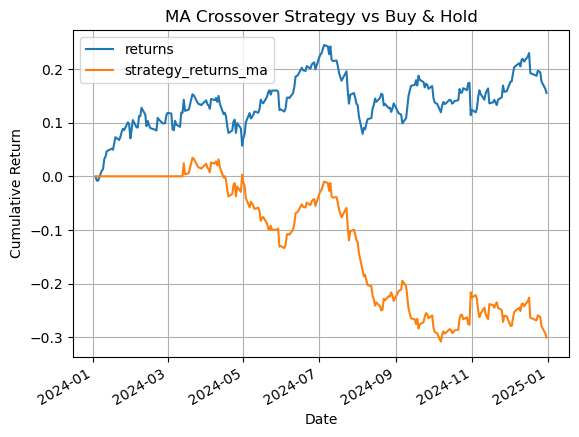

In [97]:
df[['returns', 'strategy_returns_ma']].cumsum().plot(title="MA Crossover Strategy vs Buy & Hold")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

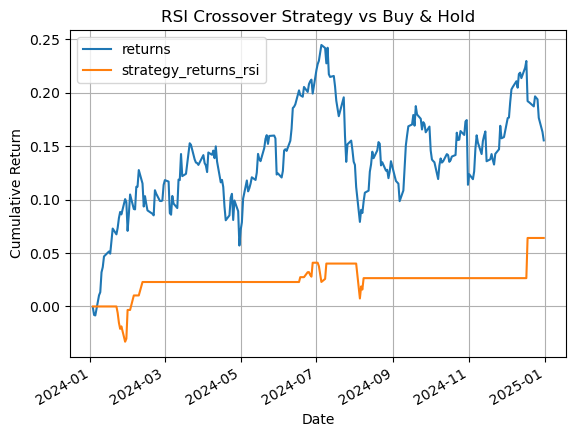

In [98]:
df[['returns', 'strategy_returns_rsi']].cumsum().plot(title="RSI Crossover Strategy vs Buy & Hold")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

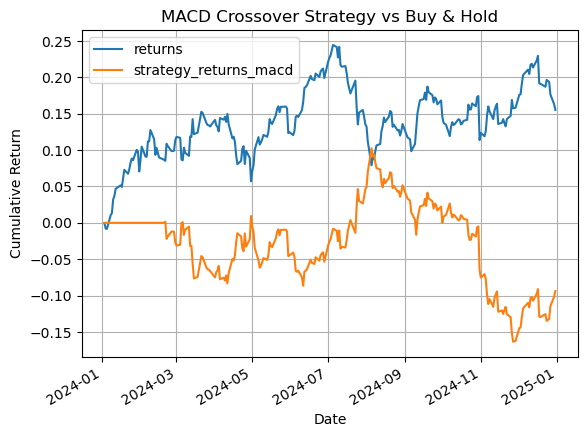

In [99]:
df[['returns', 'strategy_returns_macd']].cumsum().plot(title="MACD Crossover Strategy vs Buy & Hold")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

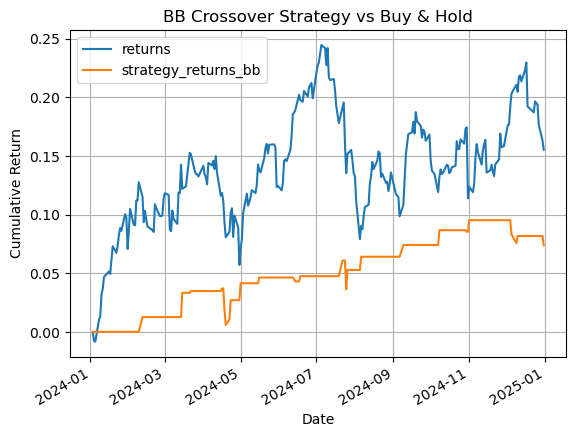

In [100]:
df[['returns', 'strategy_returns_bb']].cumsum().plot(title="BB Crossover Strategy vs Buy & Hold")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In [101]:
df['Sentiment']=np.random.choice([-1, 0, 1], size=len(df))

In [102]:
print(df['Sentiment'].value_counts())

Sentiment
 1    90
 0    84
-1    78
Name: count, dtype: int64


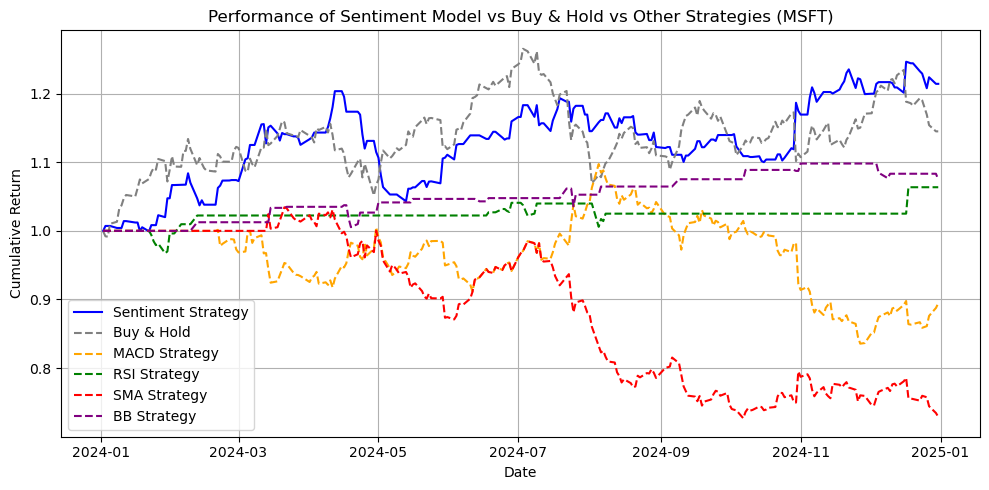

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

df = df.reset_index()
df = df.sort_values('Date')

df['Next_Close'] = df['Close'].shift(-1)
df['Return'] = (df['Next_Close'] - df['Close']) / df['Close']

df['Strategy_Return'] = df['Sentiment'].shift(0) * df['Return']


df['Model_Cumulative'] = (1 + df['Strategy_Return'].fillna(0)).cumprod()
df['BuyHold_Cumulative'] = (1 + df['Return'].fillna(0)).cumprod()
df['MACD_Cumulative'] = (1 + df['strategy_returns_macd'].fillna(0)).cumprod()
df['RSI_Cumulative'] = (1 + df['strategy_returns_rsi'].fillna(0)).cumprod()
df['SMA_Cumulative'] = (1 + df['strategy_returns_ma'].fillna(0)).cumprod()
df['BB_Cumulative'] = (1 + df['strategy_returns_bb'].fillna(0)).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Model_Cumulative'], label='Sentiment Strategy', color='blue')
plt.plot(df['Date'], df['BuyHold_Cumulative'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(df['Date'], df['MACD_Cumulative'], label='MACD Strategy', linestyle='--', color='orange')
plt.plot(df['Date'], df['RSI_Cumulative'], label='RSI Strategy', linestyle='--', color='green')
plt.plot(df['Date'], df['SMA_Cumulative'], label='SMA Strategy', linestyle='--', color='red')
plt.plot(df['Date'], df['BB_Cumulative'], label='BB Strategy', linestyle='--', color='purple')
plt.title(f"Performance of Sentiment Model vs Buy & Hold vs Other Strategies ({ticker})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px
fig = px.line(df, x='Date', y=['Model_Cumulative', 'BuyHold_Cumulative', 'MACD_Cumulative', 'RSI_Cumulative', 'SMA_Cumulative', 'BB_Cumulative'],
              title=f"Performance of Sentiment Model vs Buy & Hold vs Other Strategies ({ticker})",
              labels={'value': 'Cumulative Return', 'Date': 'Date'},
              template='plotly_white')
fig.update_traces(mode='lines')
fig.update_layout(title_x=0.5)
fig.show()
